In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
import urllib3, certifi
import calendar, datetime
from bs4 import BeautifulSoup
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib notebook
pd.set_option('max_columns',None)

# Aggregate hailstorm data

### Scrap NOAA for CSV files since 1955

In [2]:
url = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
res = req.request('GET',url)
soup = BeautifulSoup(res.data, 'html.parser')

# compile list of CSV files
files = []
for link in soup.find_all('a'):
    m = re.search('StormEvents_details.*', link.get('href'))
    if m:
        files.append(link.get('href'))

### Load hailstorm data into a Pandas DataFrame

In [3]:
# create a reverse dictionary to convert month name to number
month_name_to_num = {v: k for k,v in enumerate(calendar.month_name)}

# preallocate dataframe
columnNames = ['date','state','county','magnitude']
df = pd.DataFrame(columns = columnNames)

for file in files:
    
    # import hailstorm data
    dfTmp = pd.read_csv(url + file)
    dfTmp = dfTmp[dfTmp['EVENT_TYPE']=='Hail']
    
    if dfTmp.shape[0] > 0:
        
        # rename columns
        dfTmp = dfTmp.rename(columns={'STATE': 'state', 'CZ_NAME': 'county', 'MAGNITUDE': 'magnitude'})

        # convert date information to datetime
        dfTmp['date'] = pd.to_datetime({'year': dfTmp['YEAR'],
                                     'month': [month_name_to_num[mth] for mth in dfTmp['MONTH_NAME']],
                                     'day': dfTmp['BEGIN_DAY']})
        
        # append to master dataframe
        df = df.append(dfTmp[columnNames])
        
# drop empty rows
df = df.dropna()

# set date as index and sort
df = df.set_index('date').sort_index()

# remove entries from current year
df = df[df.index.year < datetime.date.today().year]

# format states and counties as titles
df = df.apply(lambda x: x.str.title() if x.name in ['state','county'] else x)

/Users/Najja/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Najja/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Najja/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,34,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create a new DataFrame of storm counts per state for each year

In [4]:
years = sorted(df.index.year.unique())
states = sorted(df['state'].unique())
HailStorms = pd.DataFrame(index=pd.MultiIndex.from_product([years,states], names=['year','state']), columns=['count'])
HailStorms = HailStorms.fillna(0)

s = df.groupby([df.index.year, 'state']).size()
for date, state in s.index:
    HailStorms.loc[date,state] = s.loc[date,state]
    
# arrange storm counts into a matrix
nYear = len(HailStorms.index.get_level_values(0).unique())
nState = len(HailStorms.index.get_level_values(1).unique())
stormCount = HailStorms.to_numpy().reshape(nYear, nState).T

# sort states by total storms (all years)
nTotStorm = np.sum(stormCount,axis=1)
srtIdx = sorted(range(len(stormCount)), key=lambda k: nTotStorm[k], reverse=True)

### Create a new DataFrame of storm magnitude (i.e. hail size) for all storms from each year

In [5]:
hailSize = np.append(np.arange(0,5,dtype=int), np.Inf)
   
# arrange storm counts into a matrix
stormSeverity = (df.groupby([df.index.year, pd.cut(df['magnitude'], hailSize, include_lowest=True)])
    .sum()
    .to_numpy()
    .reshape(nYear, len(hailSize)-1).T)

# fill NaNs
stormSeverity = np.nan_to_num(stormSeverity)

# normalize
stormSeverity /= stormSeverity.sum(axis=0)

# Data visualization

<IPython.core.display.Javascript object>


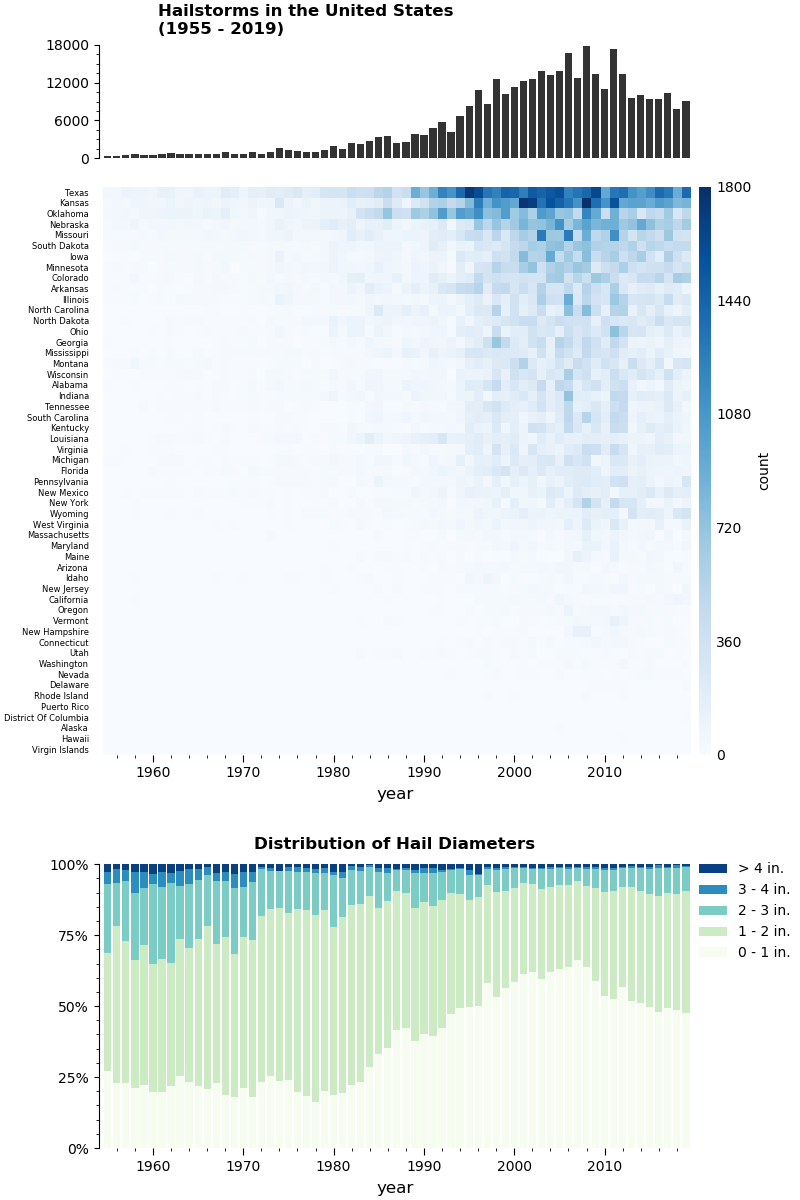

In [6]:
# x-tick tuples (index, value)
xtt = [(k,v) for k, v in enumerate(years) if v % 10 == 0]

# setup plot (3 panels)
heights = [0.2, 1, 0.01, 0.5]
fh = plt.figure(constrained_layout=True, figsize=(8,12))
gs = fh.add_gridspec(ncols=1, nrows=len(heights), height_ratios=heights)

# create subplots
for row in [0,1,len(heights)-1]:
    
    ax = fh.add_subplot(gs[row])
    
    [spine.set_visible(False) for spine in ax.spines.values()];
    
    # marginal distribution of hailstorms over all states
    if row == 0: 
        
        ax.bar(np.arange(len(years)), stormCount.sum(axis=0), width=0.8, color=(0,0,0,0.8))
        
        # labels
        ttl = ax.set_title('Hailstorms in the United States\n({} - {})'.format(years[0],years[-1]), loc='left', fontweight='bold', fontsize=12)
        ttl.set_position([0.1, 1.025])
        
        # x-ticks
        ax.set_xticks([])
        
        # y-ticks
        yt = np.linspace(0,18000,4).astype(int)
        ax.set_ylim([yt[0],yt[-1]])
        ax.set_yticks(yt)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.spines['left'].set_visible(True)
       
    # heatmap of total hailstorms per state
    elif row == 1: 
        
        colorMap = mpl.cm.Blues
        im = ax.imshow(stormCount[srtIdx,:], cmap=colorMap, vmin=0, vmax=1800, interpolation='nearest', aspect='auto');
        
        # labels
        ax.set_xlabel('year', labelpad=5, fontsize=12)
        
        # x-ticks
        ax.set_xticks([x[0] for x in xtt]);
        ax.set_xticklabels([x[1] for x in xtt]);
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.tick_params(axis='x',length=5)
        
        # y-ticks
        ax.set_yticks(np.arange(len(states)));
        ax.set_yticklabels([states[i] for i in srtIdx], fontsize=6);
        ax.tick_params(left=False)
        
        # colorbar
        cb = fh.colorbar(im,ax=ax,aspect=30,pad=0)
        cb.set_ticks(np.linspace(0,1800,6))
        cb.outline.set_visible(False)
        cb.ax.tick_params(size=0)
        cb.set_label('count')

        
    # stacked bar plot of hail sizes
    else: 
        
        cmap = mpl.cm.get_cmap('GnBu',512)
        cmap = cmap(np.linspace(0,1,stormSeverity.shape[0]))

        for mag in np.arange(stormSeverity.shape[0]):
            if mag == stormSeverity.shape[0]-1:
                label = '> {:.0f} in.'.format(hailSize[-2])
            else:
                label = '{:.0f} - {:.0f} in.'.format(hailSize[mag],hailSize[mag+1])
            ax.bar(np.arange(len(years)), stormSeverity[mag,:], bottom=np.sum(stormSeverity[:mag],axis=0), color=cmap[mag], label=label)
        
        # labels
        ttl = ax.set_title('Distribution of Hail Diameters', fontweight='bold', fontsize=12)
        ttl.set_position([0.5, 1.025])
        ax.set_xlabel('year', labelpad=5, fontsize=12)
        
        # x-ticks
        ax.set_xticks([x[0] for x in xtt]);
        ax.set_xticklabels([x[1] for x in xtt]);
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.tick_params(axis='x',length=5)
        
        # y-ticks
        yt = np.linspace(0,1,5)
        ax.set_ylim([yt[0],yt[-1]])
        ax.set_yticks(yt)
        ax.set_yticklabels(['{:.0f}%'.format(p) for p in yt*100])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.spines['left'].set_visible(True)
        
        # legend
        ax.legend();
        legH, legL = ax.get_legend_handles_labels()
        ax.legend(legH[::-1], legL[::-1], loc='upper right', bbox_to_anchor=(1.19,1.05), frameon=False);
            
    # general formatting
    ax.set_xlim([-1, len(years)-0.5])

In [7]:
plt.savefig('hailstorms_usa.pdf')